In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
import time
import numba as nb
from tqdm import tqdm


In [ ]:
dt = 100
sim_lim = 10000 #количество итераций моделирования
skip_points = 100
G = 6.67e-11
error = 1
test3_extra_bodies = 2

def random_body():
    return CosmicBody(float(rnd.randrange(1e22, 1e23, 1.0e19)),
                      np.array([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))]),
                      np.array([float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8))]))

In [29]:
#-------------Main Classes and Functions------------
@nb.njit
def norm(vec: np.ndarray):
    """
    Returns norm of vector

    Parameters
    ----------
    vec : np.ndarray
        vector.

    Returns
    -------
    float
         norm of vector.

    """
    return np.linalg.norm(vec, ord=2)


@nb.njit
def accelerate(M: float, r: np.ndarray):
    return G * M * r / norm(r) ** 3


class Star:
    def __init__(self, mass: float, radius=0.):
        """
        Initialization

        Parameters
        ----------
        mass : float
            Star mass.
        radius : float, optional
            Radius of star. The default is 0..

        Returns
        -------
        None.

        """
        self.mass = mass
        self.vec_P = [0, 0, 0]
        self.radius = radius

    def __str__(self):
        return f"mass:{np.round(self.mass,2)} radius:{self.radius}"


class CosmicBody:
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray, r: float = 0.):
        """
        Initialization

        Parameters
        ----------
        mass : float
            Object mass
        vec_v : np.ndarray
            Velocity vector.
        vec_P : np.ndarray
            Coordinate vector.
        r : float, optional
            Object radius. The default is 0. .
        Returns
        -------
        None.

        """

        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.coords = ([self.vec_P[0], self.vec_P[1], self.vec_P[2]])
        self.radius = r
        self.destroy_flag = False
        self.id = id(self)

    def __str__(self):
        return f"m:{self.mass} v:({round(self.vec_v[0],2)}, {round(self.vec_v[1],2)}, {round(self.vec_v[2],2)}) c:({round(self.vec_P[0],2)}, {round(self.vec_P[1],2)}, {round(self.vec_P[2],2)})"

    def E_k(self):
        """
        Returns
        -------
        Kinetic energy of object, type=float

        """
        return self.mass * norm(self.vec_v) ** 2 / 2


def try_destroy(self_body: CosmicBody, body: [CosmicBody, Star]):
    """
    Trying to destroy (and delete from system) some objects

    Parameters
    ----------
    self_body : CosmicBody
        first body
    body : [CosmicBody, Star]
        array of bodies

    Returns
    -------
    None.

    """
    if isinstance(body, Star):
        if norm(self_body.vec_P - body.vec_P) < 1:
            self_body.destroy_flag = True
    else:
        if norm(self_body.vec_P - body.vec_P) < 1:
            body.destroy_flag = True
            self_body.destroy_flag = True

            
def gravitate(star: Star, bodies: list):
    """
    Doing 1 iterarion of interaction between bodies in system (try_destroy function included)
    Writing new coordinates of bodies in self.coords

    Parameters
    ----------
    star : Star
        just star.
    bodies : list
        list of bodies (planets, comets, etc.).

    Returns
    -------
    None.

    """
    bodies_copy = copy.deepcopy(bodies)
    for body, body_copy in zip(bodies, bodies_copy):
        try_destroy(body, star)
        body_copy.destroy_flag = body.destroy_flag
        if body.destroy_flag == True:
            continue
        dv = accelerate(star.mass, - body.vec_P) * dt
        body.vec_v += dv
        body.vec_P += body.vec_v * dt
        for dbody in bodies:
            if dbody.id != body.id:
                try_destroy(body, dbody)
                body_copy.destroy_flag = body.destroy_flag
        for body1 in bodies_copy:
            if body1.id == body.id or body1.id == True:
                continue
            dv = accelerate(body1.mass, body_copy.vec_P - body1.vec_P)*dt
            body.vec_v += dv
            body.vec_P += body.vec_v * dt
        body.coords = np.column_stack(
            (body.coords, [body.vec_P[0], body.vec_P[1], body.vec_P[2]]))

        
def E_p(body1, body2):
    """
    returns potential energy of 2 bodies

    Parameters
    ----------

    Returns
    -------
    TYPE = float

    """
    return G * body1.mass * body2.mass / norm(body1.vec_P - body2.vec_P)


def E_full(star: Star, bodies: np.ndarray):
    """
    Returns full system energy (potential + kinetic)

    Parameters
    ----------
    star : Star
    bodies : np.ndarray
        bodies list

    Returns
    -------
    E : float
        system full energy

    """
    E = 0
    for i in range(len(bodies)):
        E += E_p(bodies[i], star) + bodies[i].E_k()
        for j in range(i + 1, len(bodies)):
            E += E_p(bodies[i], bodies[j])
    return E


def orbit_type(star: Star, body: CosmicBody):
    """
    Defines body's orbit type

    Parameters
    ----------
    star : Star
        DESCRIPTION.
    body : CosmicBody
        DESCRIPTION.

    Returns
    -------
    str
        orbit type

    """
    E = E_p(star, body) - body.E_k()
    if E > 0:
        return 'Elliptic'
    elif E < 0:
        return 'Hyperbolic'
    else:
        return 'Parabolic'
    

Earth = CosmicBody(5, np.array([1., 0., 1.]), np.array([1., 1., 1.]))
system_of_2 = np.array([random_body(), random_body()])
system_of_2_copy = copy.deepcopy(system_of_2)
system_of_3 = np.array([random_body(), random_body(), random_body()])
system_of_4 = np.array([random_body(), random_body(), random_body(), random_body()])
Sun = Star(1e31)
zero = Star(0)

Проверяем закон сохранения энергии

In [30]:
# ----------------------TESTS----------------------

def test1(star, bodies: np.ndarray):
    print('Test №1: calculating Energy error')
    E_initial = E_full(star, bodies)
    print('Initial system full energy:', E_initial)
    i = 0
    E_arr = []
    while np.abs(E_full(star, bodies)/E_initial - 1) < error and i < sim_lim:
        gravitate(star, bodies)
        i += 1
        E_arr.append(E_full(star, bodies))
    print('Final system full energy:', E_full(star, bodies))
    if i == sim_lim:
        print(
            f"for {i} iterations we have {round(np.abs(E_full(star,bodies)/E_initial-1)*100,1)}% error")
    else:
        print(f"{i} iterations needed to get {round(error*100,1)}% error")

        
test1(Sun, system_of_2)

Test №1: calculating Energy error
Initial system full energy: 9.735777527561398e+32
Final system full energy: 1.000553704546944e+33
for 10000 iterations we have 2.8% error


Проверяем работу фукнции gravitate() на 2х телах


Test №2:
m:8.252e+22 v:(-46192.93, 5384.39, -65445.39) c:(-88716180052.75, -61425144834.6, 40277930680.82)
m:1.477e+22 v:(40979.01, 104333.28, -65919.32) c:(43424615864.88, -39149982694.35, -45643152849.37)


<IPython.core.display.Javascript object>


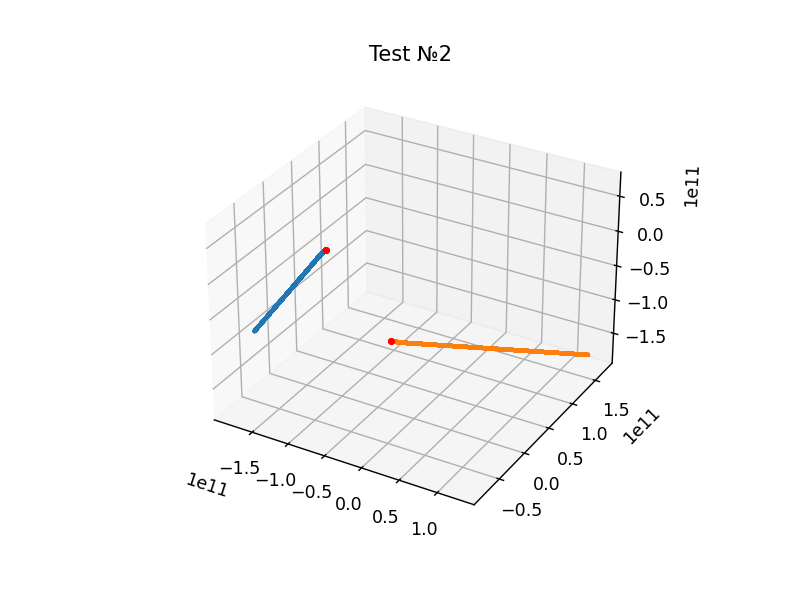

In [34]:
def test2(star, bodies: np.ndarray):
    print('\nTest №2:')
    for body in bodies:
        print(body)
    for i in range(sim_lim):
        gravitate(star, bodies)


def test2_plot(star, bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.set_xlim3d(-1e11, 1e11)
    # ax.set_ylim3d(-1e11, 1e11)
    # ax.set_zlim3d(-1e11, 1e11)
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for body in bodies:
        ax.scatter(body.coords[0][::skip_points], body.coords[1][::skip_points],
                   body.coords[2][::skip_points], marker='.', s=7)
        ax.scatter(body.coords[0][0], body.coords[1]
                   [0], body.coords[2][0], color='red', label='spawn point', s=10)
    ax.set_title('Test №2')
    
    
test2(zero, system_of_2)
test2_plot(zero, system_of_2)

Теперь то же самое, но со звездой


Test №2:
m:8.252e+22 v:(586.13, 23137.89, -52837.27) c:(-142888990891.09, 15252431314.57, -199197781607.32)
m:1.477e+22 v:(3835.93, 97275.86, -20322.05) c:(77365361604.89, 362577853695.32, -151231399112.84)


<IPython.core.display.Javascript object>


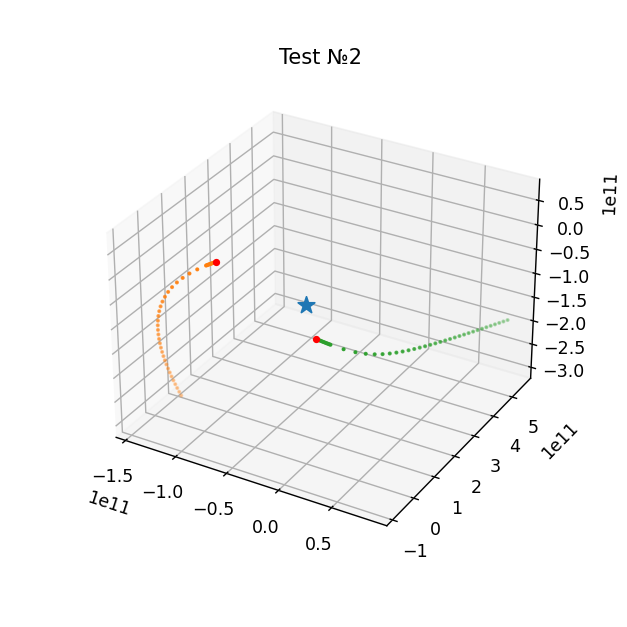

In [38]:
def test2_1(star, bodies: np.ndarray):
    print('\nTest №2:')
    for body in bodies:
        print(body)
    for i in range(sim_lim):
        gravitate(star, bodies)


def test2_1_plot(star, bodies: np.ndarray):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.set_xlim3d(-1e11, 1e11)
    # ax.set_ylim3d(-1e11, 1e11)
    # ax.set_zlim3d(-1e11, 1e11)
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for body in bodies:
        ax.scatter(body.coords[0][::skip_points], body.coords[1][::skip_points],
                   body.coords[2][::skip_points], marker='.', s=7)
        ax.scatter(body.coords[0][0], body.coords[1]
                   [0], body.coords[2][0], color='red', label='spawn point', s=10)
    ax.set_title('Test №2')
    
    
test2_1(Sun, system_of_2_copy)
test2_1_plot(Sun, system_of_2_copy)

Проверим моделирование системы, когда в случайные моменты времени появляются новые тела (на самом деле не очень реальная система получается)

In [40]:
def test3(star, bodies: np.ndarray):
    print('\nTest №3: adding bodies in random time')
    time = np.array(
        [rnd.randrange(0, sim_lim, 1) * dt for j in range(test3_extra_bodies)])
    time.sort()
    print('Random timings:', time)
    for t in range(sim_lim):
        if float(t) * dt in time:
            smthng = random_body()
            bodies = np.append(bodies, smthng)
        for body in bodies:
            gravitate(star, bodies)
    return bodies


def test3_plot(star, bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.set_xlim(-20, 20)
    # ax.set_ylim(-20, 20)
    # ax.set_zlim(-20, 20)
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for body in bodies:
        ax.scatter(body.coords[0][::skip_points], body.coords[1][::skip_points],
                   body.coords[2][::skip_points], marker='.', s=7)
        ax.scatter(body.coords[0][0], body.coords[1]
                   [0], body.coords[2][0], color='red', label='spawn point', s=10)
    ax.set_title('Test №3')
    
    
    
test3_res = test3(Sun, system_of_3)
test3_plot(Sun, test3_res)

Проверяем работу функции проверки типа орбиты (orbit_type())


Test №4: testing orbyt_type function
Elliptic


<IPython.core.display.Javascript object>


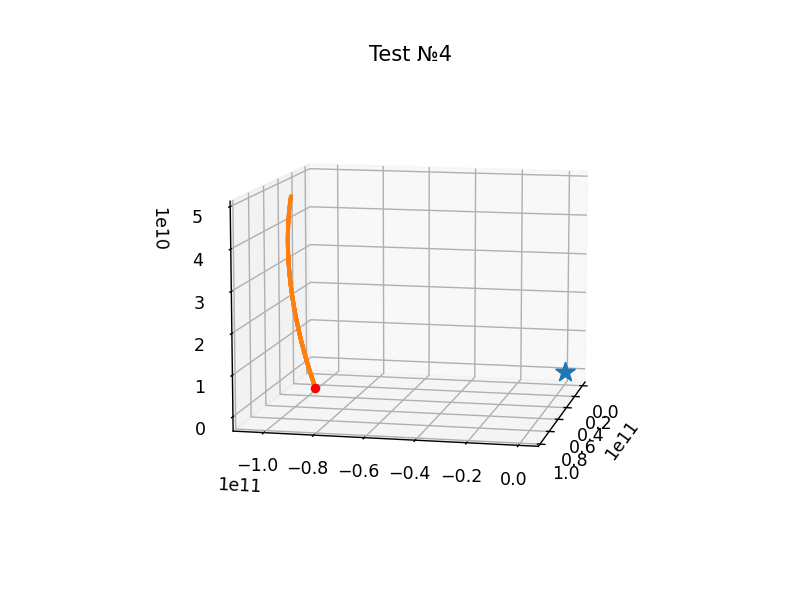

In [46]:
def test4(star, body):
    print('\nTest №4: testing orbyt_type function')
    print(orbit_type(star, body))
    for i in range(sim_lim):
        gravitate(star, np.array([body]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.set_xlim(-20, 20)
    # ax.set_ylim(-20, 20)
    # ax.set_zlim(-20, 20)
    ax.scatter(star.vec_P[0], star.vec_P[1], star.vec_P[2], marker='*', s=130)
    ax.scatter(body.coords[0][::skip_points], body.coords[1][::skip_points],
                   body.coords[2][::skip_points], marker='.', s=7)
    ax.scatter(body.coords[0][0], body.coords[1]
               [0], body.coords[2][0], color='red', label='spawn point')
    ax.set_title('Test №4')
    
    
bodddd = random_body()
test4(Sun, bodddd)

<IPython.core.display.Javascript object>


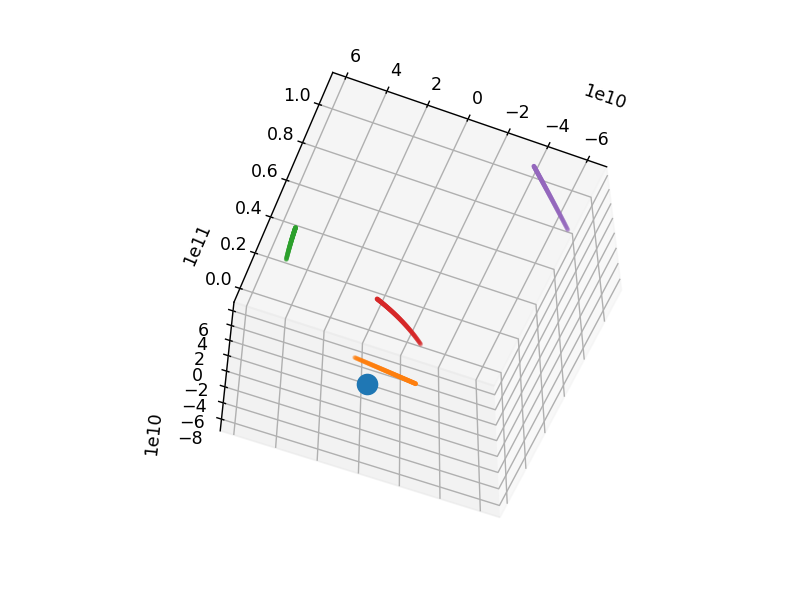

  6%|████▊                                                                         | 615/10000 [01:21<20:42,  7.55it/s]


KeyboardInterrupt: 

In [43]:
%matplotlib notebook
def test_animation(star: Star, bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.show()
    fig.canvas.draw()
    
    for t in tqdm(np.arange(0., sim_lim * dt, dt)):
        angle = 60 + 60 * t / sim_lim 
        gravitate(star, bodies)
        ax.clear()
        #ax.axes.set_xlim3d(-1e12, 1e12)
        #ax.axes.set_ylim3d(-1e12, 1e12)
        #ax.axes.set_zlim3d(-1e12, 1e12)
        
        ax.scatter(0, 0, 0,  s=130)
        for body in bodies:
            ax.scatter(body.coords[0][::skip_points/10], body.coords[1][::skip_points/10],
                   body.coords[2][::skip_points/10], s=3)
        # Изменяем угол отображения графика
        ax.view_init(30 - angle * 0.2, angle)
        # Перерисовываем фигуру
        fig.canvas.draw()
    
    
test_animation(Sun, system_of_4)